# Reading Binary Data with Numpy

Tamás Gál (tamas.gal@fau.de)

The latest version of this notebook is available at [https://github.com/Asterics2020-Obelics](https://github.com/Asterics2020-Obelics/School2019/tree/master/numpy)

**Warning**: This notebook contains all the solutions. If you are currently sitting in the `NumPy` lecture, close this immediately ;-) You will now work in a blank notebook, you don't need anything else!

In [1]:
import numpy as np
import sys

print("Python version:  {0}\n"
      "NumPy version:   {1}"
      .format(sys.version, np.__version__))

Python version:  3.7.2 (default, Feb 25 2019, 13:21:17) 
[Clang 10.0.0 (clang-1000.10.44.4)]
NumPy version:   1.16.2


In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (16, 5)
plt.rcParams['figure.dpi'] = 300

## Exercise: Read a KM3NeT Event File and create a histogram of the PMT ToTs

Use `numpy.fromfile()` and custom `dtype`s to read an event from `School2019/numpy/IO_EVT.dat`

The KM3NeT DAQ dataformat for storing an event consists of a header and two sets of hits (triggered hits and snapshot hits). The header has been skipped, so `IO_EVT.dat` only contains the **triggered** and **snapshot** hits.

#### Triggered hits:
- n_hits `[int32, little endian]`
- n_hits * triggered_hit_struct
    - optical module ID `[int32, little endian]`, example 808476737
    - PMT ID `[unsigned char (byte)]`, value between 0 and 30
    - time in nanoseconds `[uint32, big endian]`, example 90544845
    - ToT (time over threshold) `[unsigned byte]`, value between 0 and 255
    - trigger mask `[uint64, little endian]`, bitmask, typical values are 1, 3, 4, 6

#### Snapshot hits: same as triggered hits but without the `trigger mask` field

### Solution

We can use the `xxd` command to have a quick look at the binary data. If we don't know the structure, this might be a good starting point to identify some strings or recognise numbers from a proiri knowledge.

In [3]:
!xxd IO_EVT.dat |head -n 10

00000000: 0f00 0000 4160 3030 0205 659a 101d 0400  ....A`00..e.....
00000010: 0000 0000 0000 4160 3030 0305 659a 2515  ......A`00..e.%.
00000020: 0400 0000 0000 0000 5e7b 3030 0005 659a  ........^{00..e.
00000030: 6821 0400 0000 0000 0000 5e7b 3030 0105  h!........^{00..
00000040: 659a 541b 0600 0000 0000 0000 5e7b 3030  e.T.........^{00
00000050: 0a05 659a 6511 0600 0000 0000 0000 5e7b  ..e.e.........^{
00000060: 3030 1005 659a 5c1b 0600 0000 0000 0000  00..e.\.........
00000070: 5e7b 3030 1405 659a 5619 0600 0000 0000  ^{00..e.V.......
00000080: 0000 4887 3730 0105 6599 cf1a 0600 0000  ..H.70..e.......
00000090: 0000 0000 4887 3730 0b05 6599 d613 0600  ....H.70..e.....


## The hit `dtype`

We define our custom `dtype` for the hits and use the `dtype.descr` attribute as a base `dtype` for triggered hits, extended with the `triggermask` field.

In [4]:
hit_dtype = np.dtype([
    ("dom_id", "<i"),
    ("pmt_id", "B"),
    ("time", ">I"),
    ("tot", "B"),
])

trig_hit_dtype = np.dtype(hit_dtype.descr + [('triggermask', '<Q')])

The file `IO_EVT.dat` contains a single event. Opened in binary-read mode (`"rb"`), the `fobj` behaves like a stream. `np.fromfile` will call the `.read()` method with the number of bytes calculated from the given `dtype`.
According to the data format specification, the first integer (represented by `dtype='<i'` where `<` indicates that it's little endian) is the number of triggered hits.

To read the array of triggered hits, the `trig_hit_dtype` is used and the `count=n_trig_hits` argument is passed, otherwise `numpy` will read till the end of the file.

We repeat the same process for the regular (snapshot) hits.

### Parsing the binary data

In [5]:
with open("IO_EVT.dat", "rb") as fobj:
    n_trig_hits = np.fromfile(fobj, dtype='<i', count=1)[0]
    trig_hits = np.fromfile(fobj, dtype=trig_hit_dtype, count=n_trig_hits)
    
    n_hits = np.fromfile(fobj, dtype='<i', count=1)[0]
    hits = np.fromfile(fobj, dtype=hit_dtype, count=n_hits)

Let's see what we got:

In [6]:
trig_hits

array([(808476737,  2, 90544656, 29, 4), (808476737,  3, 90544677, 21, 4),
       (808483678,  0, 90544744, 33, 4), (808483678,  1, 90544724, 27, 6),
       (808483678, 10, 90544741, 17, 6), (808483678, 16, 90544732, 27, 6),
       (808483678, 20, 90544726, 25, 6), (808945480,  1, 90544591, 26, 6),
       (808945480, 11, 90544598, 19, 6), (808945480, 16, 90544592, 28, 6),
       (808949646,  8, 90544804, 31, 6), (808949646, 10, 90544823, 26, 4),
       (808949646, 11, 90544802, 22, 6), (808949646, 12, 90544804, 23, 6),
       (808982030, 14, 90544595, 17, 4)],
      dtype=[('dom_id', '<i4'), ('pmt_id', 'u1'), ('time', '>u4'), ('tot', 'u1'), ('triggermask', '<u8')])

In [7]:
hits

array([(808476737,  6, 90543934, 27), (808476737, 26, 90544817, 24),
       (808476737, 27, 90544845, 25), (808476737,  2, 90544656, 29),
       (808476737,  3, 90544677, 21), (808483667, 11, 90544676, 23),
       (808483678, 20, 90544726, 25), (808483678,  0, 90544744, 33),
       (808483678,  1, 90544724, 27), (808483678, 10, 90544741, 17),
       (808483678, 16, 90544732, 27), (808945480,  1, 90544591, 26),
       (808945480, 11, 90544598, 19), (808945480, 16, 90544592, 28),
       (808949646,  8, 90544804, 31), (808949646, 10, 90544823, 26),
       (808949646, 11, 90544802, 22), (808949646, 12, 90544804, 23),
       (808963189, 26, 90544010, 15), (808963189,  5, 90544320, 22),
       (808968978, 16, 90544260, 31), (808982030, 14, 90543675, 22),
       (808982030, 16, 90544530, 10), (808982030, 14, 90544595, 17),
       (808985283,  1, 90544450, 28), (808985283,  1, 90545130, 24),
       (809004291, 28, 90544405, 21), (809004291, 19, 90544776, 23),
       (809548770, 14, 90544049, 3

### The overall ToT distribution

We can easily access a specific attribute of all hits using dictionary-notation.

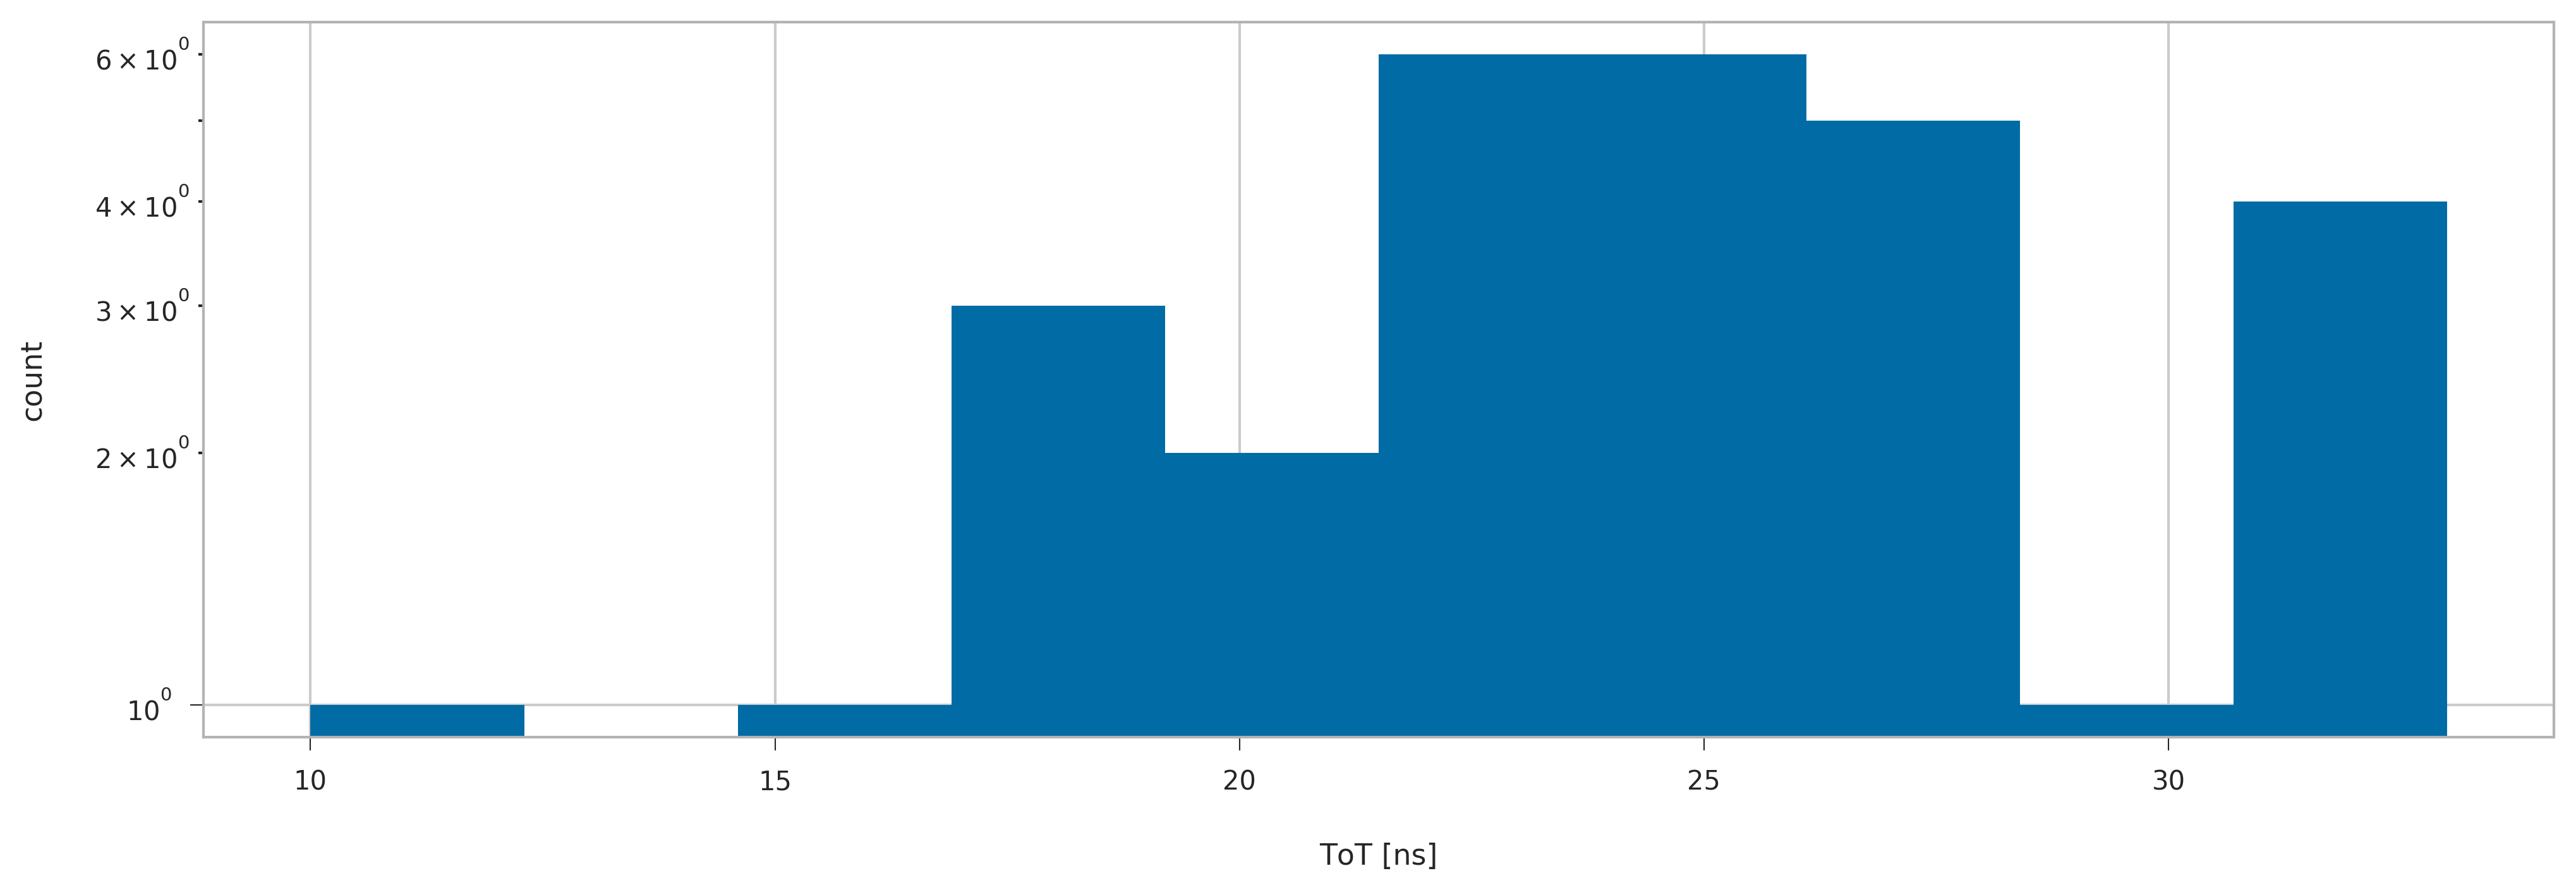

In [8]:
plt.hist(hits['tot'])
plt.xlabel('ToT [ns]')
plt.yscale('log')
plt.ylabel('count');

### Live Event Read-Out from the KM3NeT ORCA Detector

In this example we will read events directly from the ORCA detector, running in the deeps of the Mediterranean!
Install ControlHost to communicate with the detector: **`pip install controlhost`**.
To create a connection, subscribe to triggered events via the **`"IO_EVT"`** tag to **131.188.167.67**:

**The header is 48 bytes, just skip it.**

### Retrieve 100 events and create another ToT histogram from all hits!

### Unfortunately `eduroam` doesn't allow the connection, so you have to use VPN or the take the binary dump `events.dat`

```python
fobj = open("events.dat", "rb")
```

In [19]:
fobj = open("events.dat", "rb")

```python
import controlhost as ch

with ch.Client("131.188.167.67", tag="IO_EVT") as client:
    for i in range(5):
        data = client.get_message().data[48:]
        print(len(data))
```

### Solution (live connection)

In [10]:
import io
import tqdm  # for nice progress bars

def retrieve_hits(client):
    """Retrieves the hits of the next event using a ControlHost client"""
    data = io.BytesIO(client.get_message().data)  # creat a stream

    data.read(48)  # skip the first 48 bytes

    n_trig_hits = np.frombuffer(data.read(4), dtype='<i', count=1)[0]
    triggered_hits = np.frombuffer(
        data.read(trig_hit_dtype.itemsize * n_trig_hits),
        dtype=trig_hit_dtype
    )

    n_hits = np.frombuffer(data.read(4), dtype='<i', count=1)[0]
    hits = np.frombuffer(
        data.read(hit_dtype.itemsize * n_hits),
        dtype=hit_dtype
    )
    
    return trig_hits, hits

### Solution (binary file)

In [26]:
def extract_hits(filename):
    """Extract the hits from a binary dump"""
    fobj = open(filename, 'rb')
    hits = []
    triggered_hits = []
    while fobj:
        header = fobj.read(48)  # skip the first 48 bytes
        if not header:
            break

        n_trig_hits = np.frombuffer(fobj.read(4), dtype='<i', count=1)[0]
        _triggered_hits = np.frombuffer(
            fobj.read(trig_hit_dtype.itemsize * n_trig_hits),
            dtype=trig_hit_dtype
        )
        triggered_hits.append(_triggered_hits)
        
        n_hits = np.frombuffer(fobj.read(4), dtype='<i', count=1)[0]
        _hits = np.frombuffer(
            fobj.read(hit_dtype.itemsize * n_hits),
            dtype=hit_dtype
        )
        hits.append(_hits)
        
    
    fobj.close()
    return trig_hits, hits

### Gathering hits data (live connection)

In [11]:
tots = []
with ch.Client("131.188.167.67", tag="IO_EVT") as client:
    for i in tqdm.trange(100):
        trig_hits, hits = retrieve_hits(client)
        tots.append(hits['tot'])

100%|██████████| 100/100 [00:38<00:00,  3.19it/s]


### Extracting hits (binary file)

In [28]:
triggered_hits, hits = extract_hits("events.dat")
tots = [h['tot'] for h in  hits]

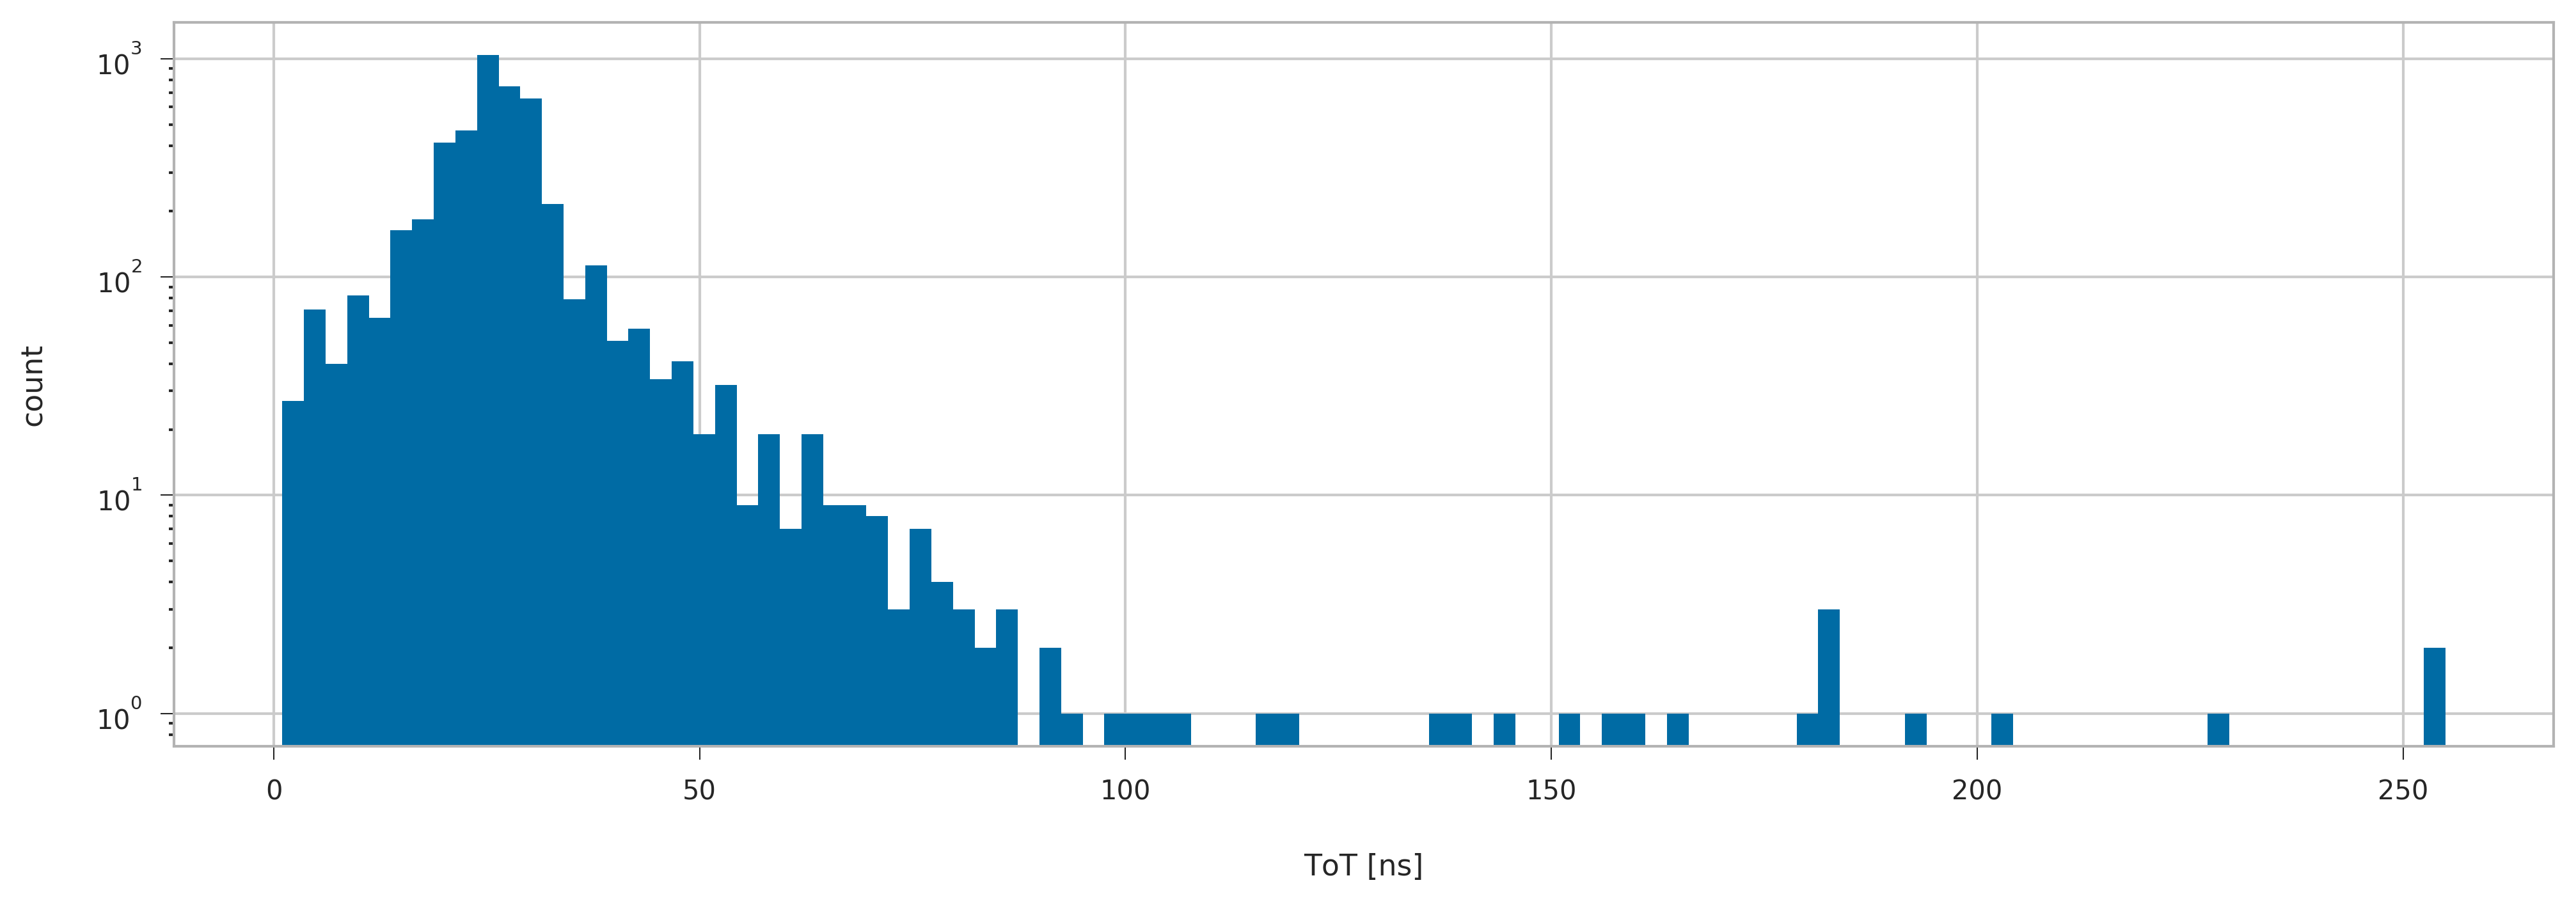

In [29]:
plt.hist(np.concatenate(tots).ravel(), bins=100)
plt.xlabel('ToT [ns]')
plt.yscale('log')
plt.ylabel('count');

## Acknowledgements
![](images/eu_asterics.png)

This tutorial was supported by the H2020-Astronomy ESFRI and Research Infrastructure Cluster (Grant Agreement number: 653477).